In [5]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
from IPython.display import Audio

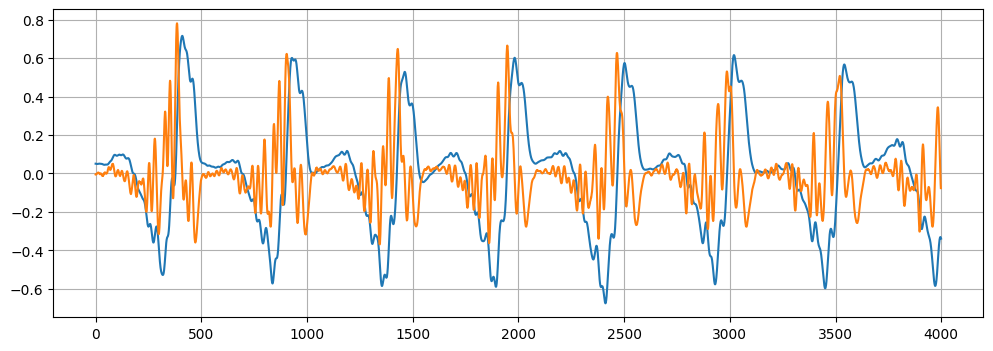

In [65]:
step = 50000
plt.figure(figsize=(12, 4))
spf = wave.open("16bit/Dee light [2024-03-19 212235].wav.wav", "rb")
signal = spf.readframes(spf.getnframes())
osc_bytes = signal[step:step+8000]
osc_np = np.frombuffer(osc_bytes,dtype="int16") 
osc_np_norm = osc_np/(2 ** 16/2)
plt.plot(osc_np_norm)
plt.plot(np.diff(osc_np_norm,n=1)*20)
plt.grid()
plt.show()

In [40]:
Audio(data=osc_np,rate=spf.getframerate())

Transient detection is a complex topic, but a simple and common approach is to use an envelope follower on the absolute value of the slope data, then find points where the envelope exceeds a certain threshold. Here's a basic implementation in Python using numpy:



In [ ]:
import numpy as np

def calculate_slopes(audio_data):
    # Ensure the input is a numpy array
    audio_data = np.array(audio_data)
    
    # Calculate the differences between each element and the previous one
    slopes = np.diff(audio_data)
    
    return slopes

def detect_transients(audio_data, threshold=0.5, attack_coeff=0.9, release_coeff=0.9):
    slopes = calculate_slopes(audio_data)
    envelope = 0
    transients = []
    
    for i, slope in enumerate(slopes):
        # Calculate the envelope
        if abs(slope) > envelope:
            envelope = attack_coeff * (envelope - abs(slope)) + abs(slope)
        else:
            envelope = release_coeff * (envelope - abs(slope)) + abs(slope)
        
        # If the envelope exceeds the threshold, we have a transient
        if envelope > threshold:
            transients.append(i)
    
    return transients



This code first calculates the slopes of the audio data, then iterates over the slopes. For each slope, it calculates an envelope value, which is a sort of smoothed, lagging version of the absolute slope. If the envelope exceeds a given threshold, it considers that point a transient and adds it to the list of transients.

The `attack_coeff` and `release_coeff` parameters control how quickly the envelope responds to changes in the slope. Values close to 1 make the envelope respond slowly (more smoothing), while values close to 0 make it respond quickly (less smoothing).

This is a very basic form of transient detection and may not work well for all types of audio data. More advanced methods involve more complex signal processing techniques.

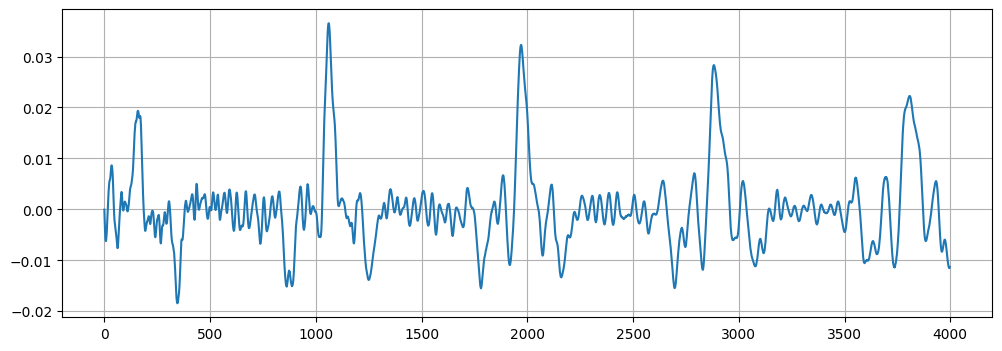

In [47]:
plt.figure(figsize=(12, 4))
spf = wave.open("16bit/Dee light [2024-03-19 212235].wav.wav", "rb")
signal = spf.readframes(spf.getnframes())
osc_bytes = signal[4000:12000]
osc_np = np.frombuffer(osc_bytes,dtype="int16") 
osc_np_norm = osc_np/(2 ** 16/2)
plt.plot(np.diff(osc_np_norm,n=1))
plt.grid()
plt.show()


#osc_np[1000]

In [55]:
def draw_wavs(file_name):
    spf = wave.open(file_name, "rb")

    signal = spf.readframes(-1)

    fig, plots = plt.subplots(8, 2,figsize=(20,40))

    counter = 0
    for i,row_plot in enumerate(plots):
        for j,plot in enumerate(row_plot):
            osc_bytes = signal[counter*12000:(counter+1)*12000]
            osc_np = np.frombuffer(osc_bytes,dtype="int32") 
            osc_np_norm = osc_np/(2 ** 16/2)
            plot.plot(osc_np_norm)
            plot.plot(np.diff(osc_np_norm,n=1)*20)
            # plot.plot(osc_np)
            plot.grid()
            #plot.axis('off')
            counter += 1

    fig.savefig('images_60.png')        

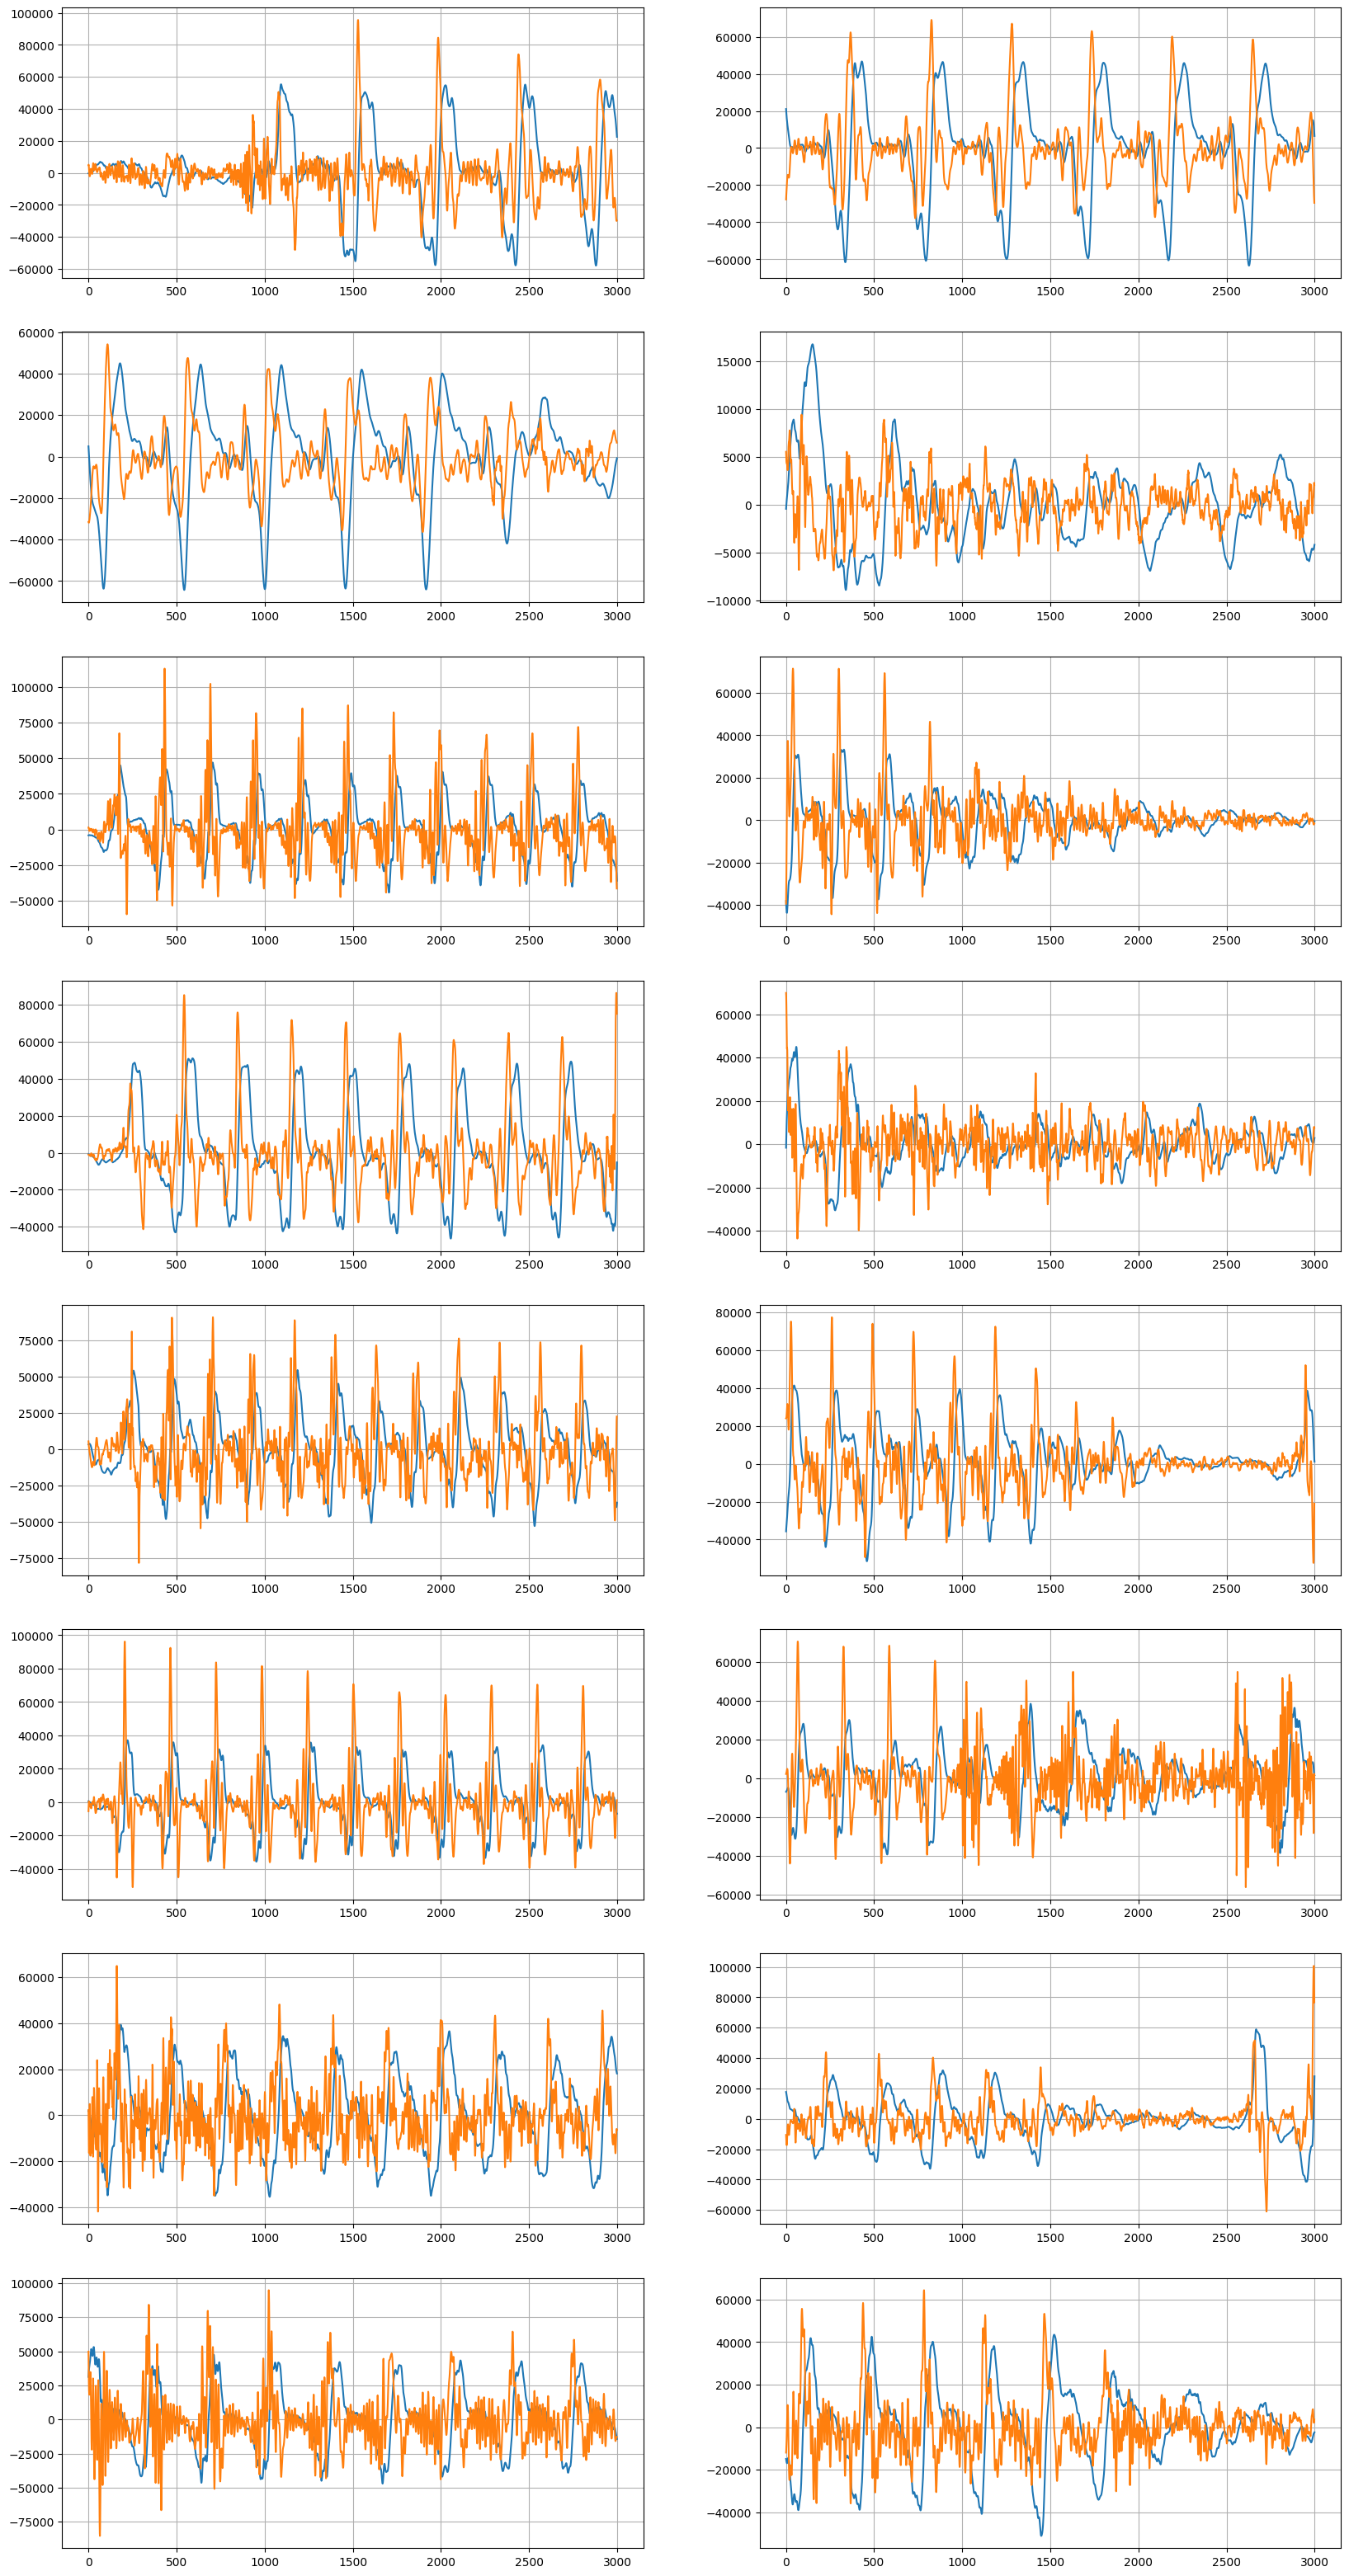

In [56]:
draw_wavs("16bit/Dee light [2024-03-19 212235].wav.wav")
# waves to add
#9,30,34,48

In [73]:
import audioop

wav_in = wave.open("AKWF_60_ordered.wav", mode='rb')
all_frames = wav_in.readframes(wav_in.getnframes())

wav_data = b''
for i in keep:
    wav_data += all_frames[(i-1)*1200:(i)*1200]

#130.8128
#146.8324
sample_rate_change = 147.1/131
wav_data = audioop.ratecv(wav_data, 2, 1, 44100, 49621, None)
wave_out = wave.open("AKWF_SMALL.wav", mode='wb')
wave_out.setnchannels(1) # mono
wave_out.setsampwidth(2)
wave_out.setframerate(44100)
#wave_out.setnframes(len(keep)*1200)
wave_out.writeframesraw(wav_data)
wave_out.close()

In [87]:
wav_in_sin = wave.open("1_sin.wav", mode='rb')
all_frames = wav_in.readframes(wav_in.getnframes())
len(all_frames)

734

In [47]:

wav_in = wave.open("AKWF_SMALL.wav", mode='rb')
all_frames = wav_in.readframes(wav_in.getnframes())

sample_rate_change = 147.1/131
wav_data = audioop.ratecv(all_frames, 2, 1, 44100, 22050, None)
wave_out = wave.open("AKWF_SMALL_12.wav", mode='wb')
wave_out.setnchannels(1) # mono
wave_out.setsampwidth(2)
wave_out.setframerate(44100)
#wave_out.setnframes(len(keep)*1200)
wave_out.writeframesraw(wav_data[0])
wave_out.close()